Import python libraries required for the script

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rfpimp import *
from rfpimp import *
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score


Read the CSV files

In [2]:
df = pd.read_csv('VMI_Data_BP2_V02_AK6_mod02.csv')
print(df.columns)

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'LFT_SPLICE_LENGTH',
       'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'BP2_S8_L',
       'BP2_S7_L', 'BP2_S6_L', 'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L',
       'BP2_S1_ML', 'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R',
       'BP2_S5_R', 'BP2_S6_R', 'BP2_S7_R', 'BP2_S8_R', 'PART_LENGTH',
       'LFT_SPLICE_DELTA', 'LFT_SPLICE_PREV', 'LFT_SPLICE_MA5',
       'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50',
       'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20',
       'LFT_SPLICE_SLOPE50', 'MID_SPLICE_DELTA', 'MID_SPLICE_PREV',
       'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
       'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10',
       'MID_SPLICE_SLOPE20', 'MID_SPLICE_SLOPE50', 'RHT_SPLICE_DELTA',
       'RHT_SPLICE_PREV', 'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10',
       'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5',
       'RHT_SPLICE_SLOPE10', 'RHT_SPLICE_SLOPE20

In [3]:
df = df.drop(['LFT_SPLICE_LENGTH', 'MID_SPLICE_LENGTH', 'RHT_SPLICE_LENGTH', 'SPLICE_OK', 'LFT_SPLICE_GRADE', 
              'MID_SPLICE_GRADE', 'RHT_SPLICE_GRADE', 'LFT_SPLICE_DELTA', 'MID_SPLICE_DELTA', 'RHT_SPLICE_DELTA',
              'LFT_SPLICE_MA5', 'LFT_SPLICE_MA10', 'LFT_SPLICE_MA20', 'LFT_SPLICE_MA50', 
              'LFT_SPLICE_SLOPE5', 'LFT_SPLICE_SLOPE10', 'LFT_SPLICE_SLOPE20', 'LFT_SPLICE_SLOPE50', 
              'MID_SPLICE_MA5', 'MID_SPLICE_MA10', 'MID_SPLICE_MA20',
              'MID_SPLICE_MA50', 'MID_SPLICE_SLOPE5', 'MID_SPLICE_SLOPE10', 'MID_SPLICE_SLOPE20',
              'MID_SPLICE_SLOPE50',  'RHT_SPLICE_MA5', 'RHT_SPLICE_MA10', 
              'RHT_SPLICE_MA20', 'RHT_SPLICE_MA50', 'RHT_SPLICE_SLOPE5', 'RHT_SPLICE_SLOPE10',
              'RHT_SPLICE_SLOPE20', 'RHT_SPLICE_SLOPE50'
             ], axis=1)

print(df.columns)

# for col in df.columns:
#     if len(df[col].unique()) == 1:
#         df = df.drop(col,inplace=True,axis=1)
        
# print(df.columns)
# df['SPLICE_GRADE'].head

Index(['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP2_S8_L', 'BP2_S7_L', 'BP2_S6_L',
       'BP2_S5_L', 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L', 'BP2_S1_ML',
       'BP2_S1_MR', 'BP2_S2_R', 'BP2_S3_R', 'BP2_S4_R', 'BP2_S5_R', 'BP2_S6_R',
       'BP2_S7_R', 'BP2_S8_R', 'PART_LENGTH', 'LFT_SPLICE_PREV',
       'MID_SPLICE_PREV', 'RHT_SPLICE_PREV', 'SPLICE_GRADE'],
      dtype='object')


In [4]:
print(df.shape)
# df = df.drop_duplicates(subset=['CUT_LENGTH', 'CONV_WAIT_TIME', 'BP2_S8_L', 'BP2_S7_L', 'BP2_S6_L', 'BP2_S5_L', 
#                                 'BP2_S4_L', 'BP2_S3_L', 'BP2_S2_L', 'BP2_S1_ML', 'BP2_S1_MR', 'BP2_S2_R', 
#                                 'BP2_S3_R', 'BP2_S4_R', 'BP2_S5_R', 'BP2_S6_R', 'BP2_S7_R', 'BP2_S8_R'])
df = df.drop_duplicates()
print(df.shape)
# df.head

(118739, 23)
(118739, 23)


Check the columns in the data

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
df = df.dropna()

                Total  Percent
SPLICE_GRADE        0      0.0
BP2_S1_MR           0      0.0
CONV_WAIT_TIME      0      0.0
BP2_S8_L            0      0.0
BP2_S7_L            0      0.0
BP2_S6_L            0      0.0
BP2_S5_L            0      0.0
BP2_S4_L            0      0.0
BP2_S3_L            0      0.0
BP2_S2_L            0      0.0


In [6]:
# pd.DataFrame({'count' : df.groupby(['SPLICE_GRADE'])['CUT_LENGTH'].size()}).reset_index()
df['SPLICE_GRADE'].value_counts()

OK      97554
Bad     21064
Good      121
Name: SPLICE_GRADE, dtype: int64

In [7]:
def numericSG(row):
    if row['SPLICE_GRADE'] == 'Bad':
        return 0
    if row['SPLICE_GRADE'] == 'OK' :
        return 1
    return 2

def inverse(x):
    if x==0: 
        return 0
    return 1/x

In [8]:
# df[(df['SPLICE_GRADE']=="Good")]=2
# df[(df['SPLICE_GRADE']=="OK")]=1
# df[(df['SPLICE_GRADE']=="Bad")]=0
# df.head

# df = df.groupby('SPLICE_GRADE', group_keys=False).apply(lambda x: x.sample(120))
# df['SPLICE_GRADE'] = df.apply(numericSG, axis=1) 

spliceGrade = {'Bad': 0, 'OK': 1, 'Good': 1} 
# spliceGrade = {'Bad': 0, 'OK': 1, 'Good': 2} 
df.SPLICE_GRADE = [spliceGrade[item] for item in df.SPLICE_GRADE] 


# df.to_csv('temp.csv', header=True, index=False)

In [9]:
# df['SPLICE_GRADE'].to_dict()

In [10]:
# #scatter plot
# fig = plt.figure(figsize=(7, 7))
# ax = sns.scatterplot(x="SPLICE_GRADE", y="CUT_LENGTH", hue="SPLICE_GRADE", palette=['r', 'b', 'g']
#                      ,data=df)  #, palette=dict(Good='g', OK='b', Bad='r')

 
# # sns.violinplot(x="SPLICE_GRADE", y="CUT_LENGTH", data=df)
# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
X = df.drop(['SPLICE_GRADE'], axis=1)
y = df['SPLICE_GRADE']
y = y.astype('int')

In [12]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, shuffle=True)

# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
rfc = RandomForestClassifier(n_estimators=500, warm_start=True, n_jobs=-1, random_state=7)
# rfc = RandomForestClassifier(n_estimators=500, warm_start=True)
scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
print(scores)

# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

[0.60993684 0.81616842 0.82745263 0.80724211 0.79526697 0.76762402
 0.78775373 0.82422303 0.8173166  0.82144361]
0.7874427956963712


In [13]:
# XGB = XGBClassifier(max_depth=5, n_estimators=500)

# # rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
# # rf.fit(X_train, y_train)

# # imp = importances(rf, X_test, y_test) # permutation
# # viz = plot_importances(imp)
# # viz.view()

# model = XGBClassifier()
# model.fit(X_train, y_train)

# y2_XGB_model = model.predict(X_test)
# print("XGBClassifier Accuracy :", accuracy_score(y_test, y2_XGB_model))

# # plot feature importance
# plot_importance(model)
# plt.show()

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
rfc = RandomForestClassifier(n_estimators=500, warm_start=True, n_jobs=-1, random_state=7)
rfc.fit(X_train,y_train)
y2_model = rfc.predict(X_test)

# print(rfc.predict([1609]))
# print(rfc.predict([[1713.377]]))


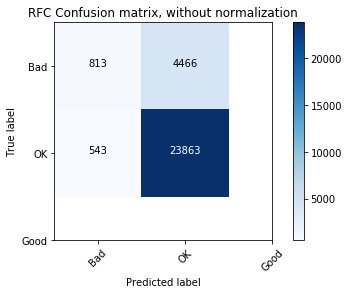

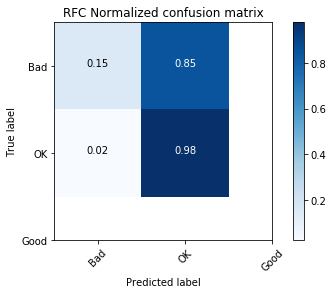

In [16]:
target_names = ['Bad', 'OK', 'Good']
class_names = target_names

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y2_model)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='RFC Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='RFC Normalized confusion matrix')

plt.show();

In [17]:
# search for an optimal value of n_estimators for rfc
# k_range = list(range(50, 501, 50))
# k_scores = []
# for k in k_range:
#     rfc = RandomForestClassifier(n_estimators=k, warm_start=True, n_jobs=-1, random_state=7)
#     scores = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
#     k_scores.append(scores.mean())
#     print(k, ' -- ', scores)
# print(k_scores)

In [18]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(k_range, k_scores)
# plt.xlabel('Value of n_estimators for RFC')
# plt.ylabel('Cross-Validated Accuracy')

In [19]:
# https://github.com/justmarkham/scikit-learn-videos/blob/master/07_cross_validation.ipynb

In [20]:
# https://github.com/justmarkham/scikit-learn-videos

In [21]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_multiclass.html#sphx-glr-auto-examples-calibration-plot-calibration-multiclass-py

In [22]:
p = rfc.predict_proba(X_test)


In [23]:
type(p)
p[:,1]

array([0.94, 0.97, 0.95, ..., 0.91, 0.89, 0.8 ])

In [39]:
def function(array):
#     print (array, "->", array[0], " , " , array[1])
    if (array[0] > 0.75):
        return 'Bad'
    if (array[1] > 0.75):
        return 'Good'
    return 'DoNotKnow'

def BadProb(array):
    return array[0]

def GoodProb(array):
    return array[1]

In [40]:
q = np.apply_along_axis(function, 1, p)
g = np.apply_along_axis(GoodProb, 1, p)
b = np.apply_along_axis(BadProb, 1, p)

In [26]:
import sys 
np.set_printoptions(threshold=sys.maxsize)
print(q)

['Good' 'Good' 'Good' 'Good' 'Good' 'Good' 'Low ' 'Low ' 'Good' 'Low '
 'Low ' 'Low ' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good' 'Good' 'Good'
 'Good' 'Good' 'Good' 'Good' 'Good' 'Low ' 'Low ' 'Good' 'Good' 'Good'
 'Good' 'Good' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good'
 'Good' 'Low ' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Low ' 'Low '
 'Good' 'Low ' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good' 'Low ' 'Good'
 'Good' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Good'
 'Good' 'Bad' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Low '
 'Good' 'Good' 'Good' 'Good' 'Good' 'Low ' 'Good' 'Low ' 'Good' 'Good'
 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good' 'Good' 'Good' 'Bad' 'Low '
 'Low ' 'Good' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Low ' 'Good' 'Good'
 'Low ' 'Good' 'Low ' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good'
 'Good' 'Low ' 'Good' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Bad'
 'Good' 'Good' 'Low ' 'Good' 'Good' 'Good' 'Good' 'Good' 'Good' 'Low '
 'Good' '

In [41]:
# my_list = map(lambda x: x[0], q)
my_list1 = map(lambda x: x, q)
qSeries = pd.Series(my_list1)

my_list2 = map(lambda x: x, b)
bSeries = pd.Series(my_list2)

my_list3 = map(lambda x: x, g)
gSeries = pd.Series(my_list3)

In [28]:
qSeries.value_counts()

Good    21958
Low      7570
Bad       157
dtype: int64

In [33]:
X_test['SPLICE_GRADE_ORIG'] = y_test
# y_test.columns

X_test = X_test.assign(SPLICE_GRADE_ORIG=y_test.values)

C:\Users\SajidPatel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
qdf = pd.DataFrame(qSeries) #.transpose()
bdf = pd.DataFrame(bSeries) 
gdf = pd.DataFrame(gSeries) 
# X_test['SPLICE_GRADE_PRED'] = qdf.iloc[:,0]
X_test = X_test.assign(SPLICE_GRADE_PRED=qdf.values)
X_test = X_test.assign(BAD_PROB=bdf.values)
X_test = X_test.assign(GOOD_PROB=gdf.values)

In [36]:
qdf.head
# X_test['SPLICE_GRADE_PRED']
# X_test.shape
# qdf.shape

<bound method NDFrame.head of           0
0      Good
1      Good
2      Good
3      Good
4      Good
5      Good
6      Low 
7      Low 
8      Good
9      Low 
10     Low 
11     Low 
12     Low 
13     Good
14     Good
15     Good
16     Good
17     Good
18     Good
19     Good
20     Good
21     Good
22     Good
23     Good
24     Good
25     Low 
26     Low 
27     Good
28     Good
29     Good
...     ...
29655  Good
29656  Good
29657  Good
29658  Good
29659  Low 
29660  Good
29661  Good
29662  Good
29663  Good
29664  Low 
29665  Good
29666  Good
29667  Good
29668  Low 
29669  Good
29670  Good
29671  Good
29672  Low 
29673  Good
29674  Good
29675  Good
29676  Good
29677  Low 
29678  Low 
29679  Good
29680  Good
29681  Good
29682  Good
29683  Good
29684  Good

[29685 rows x 1 columns]>

In [43]:
X_test.to_csv('X_test.csv', header=True, index=False)

In [37]:
X_test.head

<bound method NDFrame.head of         CUT_LENGTH  CONV_WAIT_TIME  BP2_S8_L  BP2_S7_L  BP2_S6_L  BP2_S5_L  \
68852     1710.617        77.21600       0.0       0.0       0.0      0.00   
94337     1710.488        22.10900       0.0       0.0       0.0      0.00   
54533     1713.389        42.62300       0.0       0.0       0.0      0.00   
53729     1711.117        28.09200       0.0       0.0       0.0      0.00   
55176     1710.884        30.33100       0.0       0.0       0.0      0.00   
78163     1711.583        28.60700       0.0       0.0       0.0      0.00   
11497     1714.267        29.90400       0.0       0.0       0.0      0.04   
66637     1711.625       894.57100       0.0       0.0       0.0      0.00   
12967     1712.086        48.87100       0.0       0.0       0.0      0.00   
38260     1712.858       170.52700       0.0       0.0       0.0      0.00   
66304     1713.129        26.73400       0.0       0.0       0.0      0.00   
2284      1712.681       173.41000

In [ ]:
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn
# https://scikit-learn.org/stable/modules/calibration.html